# One Hidden Layer Neural Network

We have seen how tensors work so far and how "autograd" is our handy gradient calculator. Let's try using the same toy measurement dataset from the previous "02" notebook with the simplest neural network. That is, a linear model single hidden layer with activation. We will use a `tanh` activation function since it is easy to understand.

Thinking about basis functions, linear combinations of activation functions can approximate any function.

How about trying a different optimizer like stochastic gradient descent (SGD). Before training our network, let's split the data into a training and validation set.

In [1]:
%matplotlib inline

In [2]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

Load the data and convert them to column vectors/tensors

In [3]:
# Known Celsius temperature
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_c = torch.tensor(t_c).unsqueeze(1)

# Unknown temperature
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_u = torch.tensor(t_u).unsqueeze(1)

Split into training and validation sets.

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.34 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  2,  4,  0,  8,  3,  7, 10]), tensor([6, 9, 5]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

Redefine the training loop method to include a generalized `torch.nn.Module` model and loss function.

In [6]:
def training_loop(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    t_u_train,
    t_u_val,
    t_c_train,
    t_c_val
):
    """Training loop for toy temperature data using an neural network module

    Parameters
    ----------
    n_epochs : int
        Number of iterations
    optimizer : torch.optim.Optimizer
        Optimizer class
    t_u_train : torch.Tensor
        Unknown temperature tensor for training
    t_u_val : torch.Tensor
        Target known temperature tensor for validation
    t_c_train : torch.Tensor
        Known temperature tensor for training
    t_c_val : torch.Tensor
        Known temperature tensor for validation
    Returns
    -------
    None
    """
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch < 5 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


Now let's define a neural network with named layers to help elucidate the functionality.

The number of nodes is an "art" and depends on the application. As we are using a simple NN model, the number of parameters does not need to be large. So let's pick 10. The optimizer will be SGD this time.

In [7]:
n_nodes = 10

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),  # The Linear method required args are the number of input features, output features
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_u_train,
    t_u_val = t_u_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_u_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 221.3723, Validation loss 76.4708
Epoch 2, Training loss 215.9396, Validation loss 72.7296
Epoch 3, Training loss 210.7430, Validation loss 69.1874
Epoch 4, Training loss 205.7722, Validation loss 65.8348
Epoch 1000, Training loss 96.5897, Validation loss 28.4832
Epoch 2000, Training loss 96.5897, Validation loss 28.4832
Epoch 3000, Training loss 96.5897, Validation loss 28.4832
Epoch 4000, Training loss 96.5896, Validation loss 28.4832
Epoch 5000, Training loss 96.5896, Validation loss 28.4832
output tensor([[11.4375],
        [11.4375],
        [11.4375]], grad_fn=<AddmmBackward0>)
answer tensor([[ 3.],
        [13.],
        [ 8.]])
hidden tensor([[ 1.4152e-03],
        [ 0.0000e+00],
        [ 2.8994e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 5.0477e-03],
        [ 0.0000e+00],
        [-2.9864e-03],
        [-2.5257e-04],
        [ 0.0000e+00]])


The training and validation sets are small, so it is hard to gauge the convergence. Let's plot it

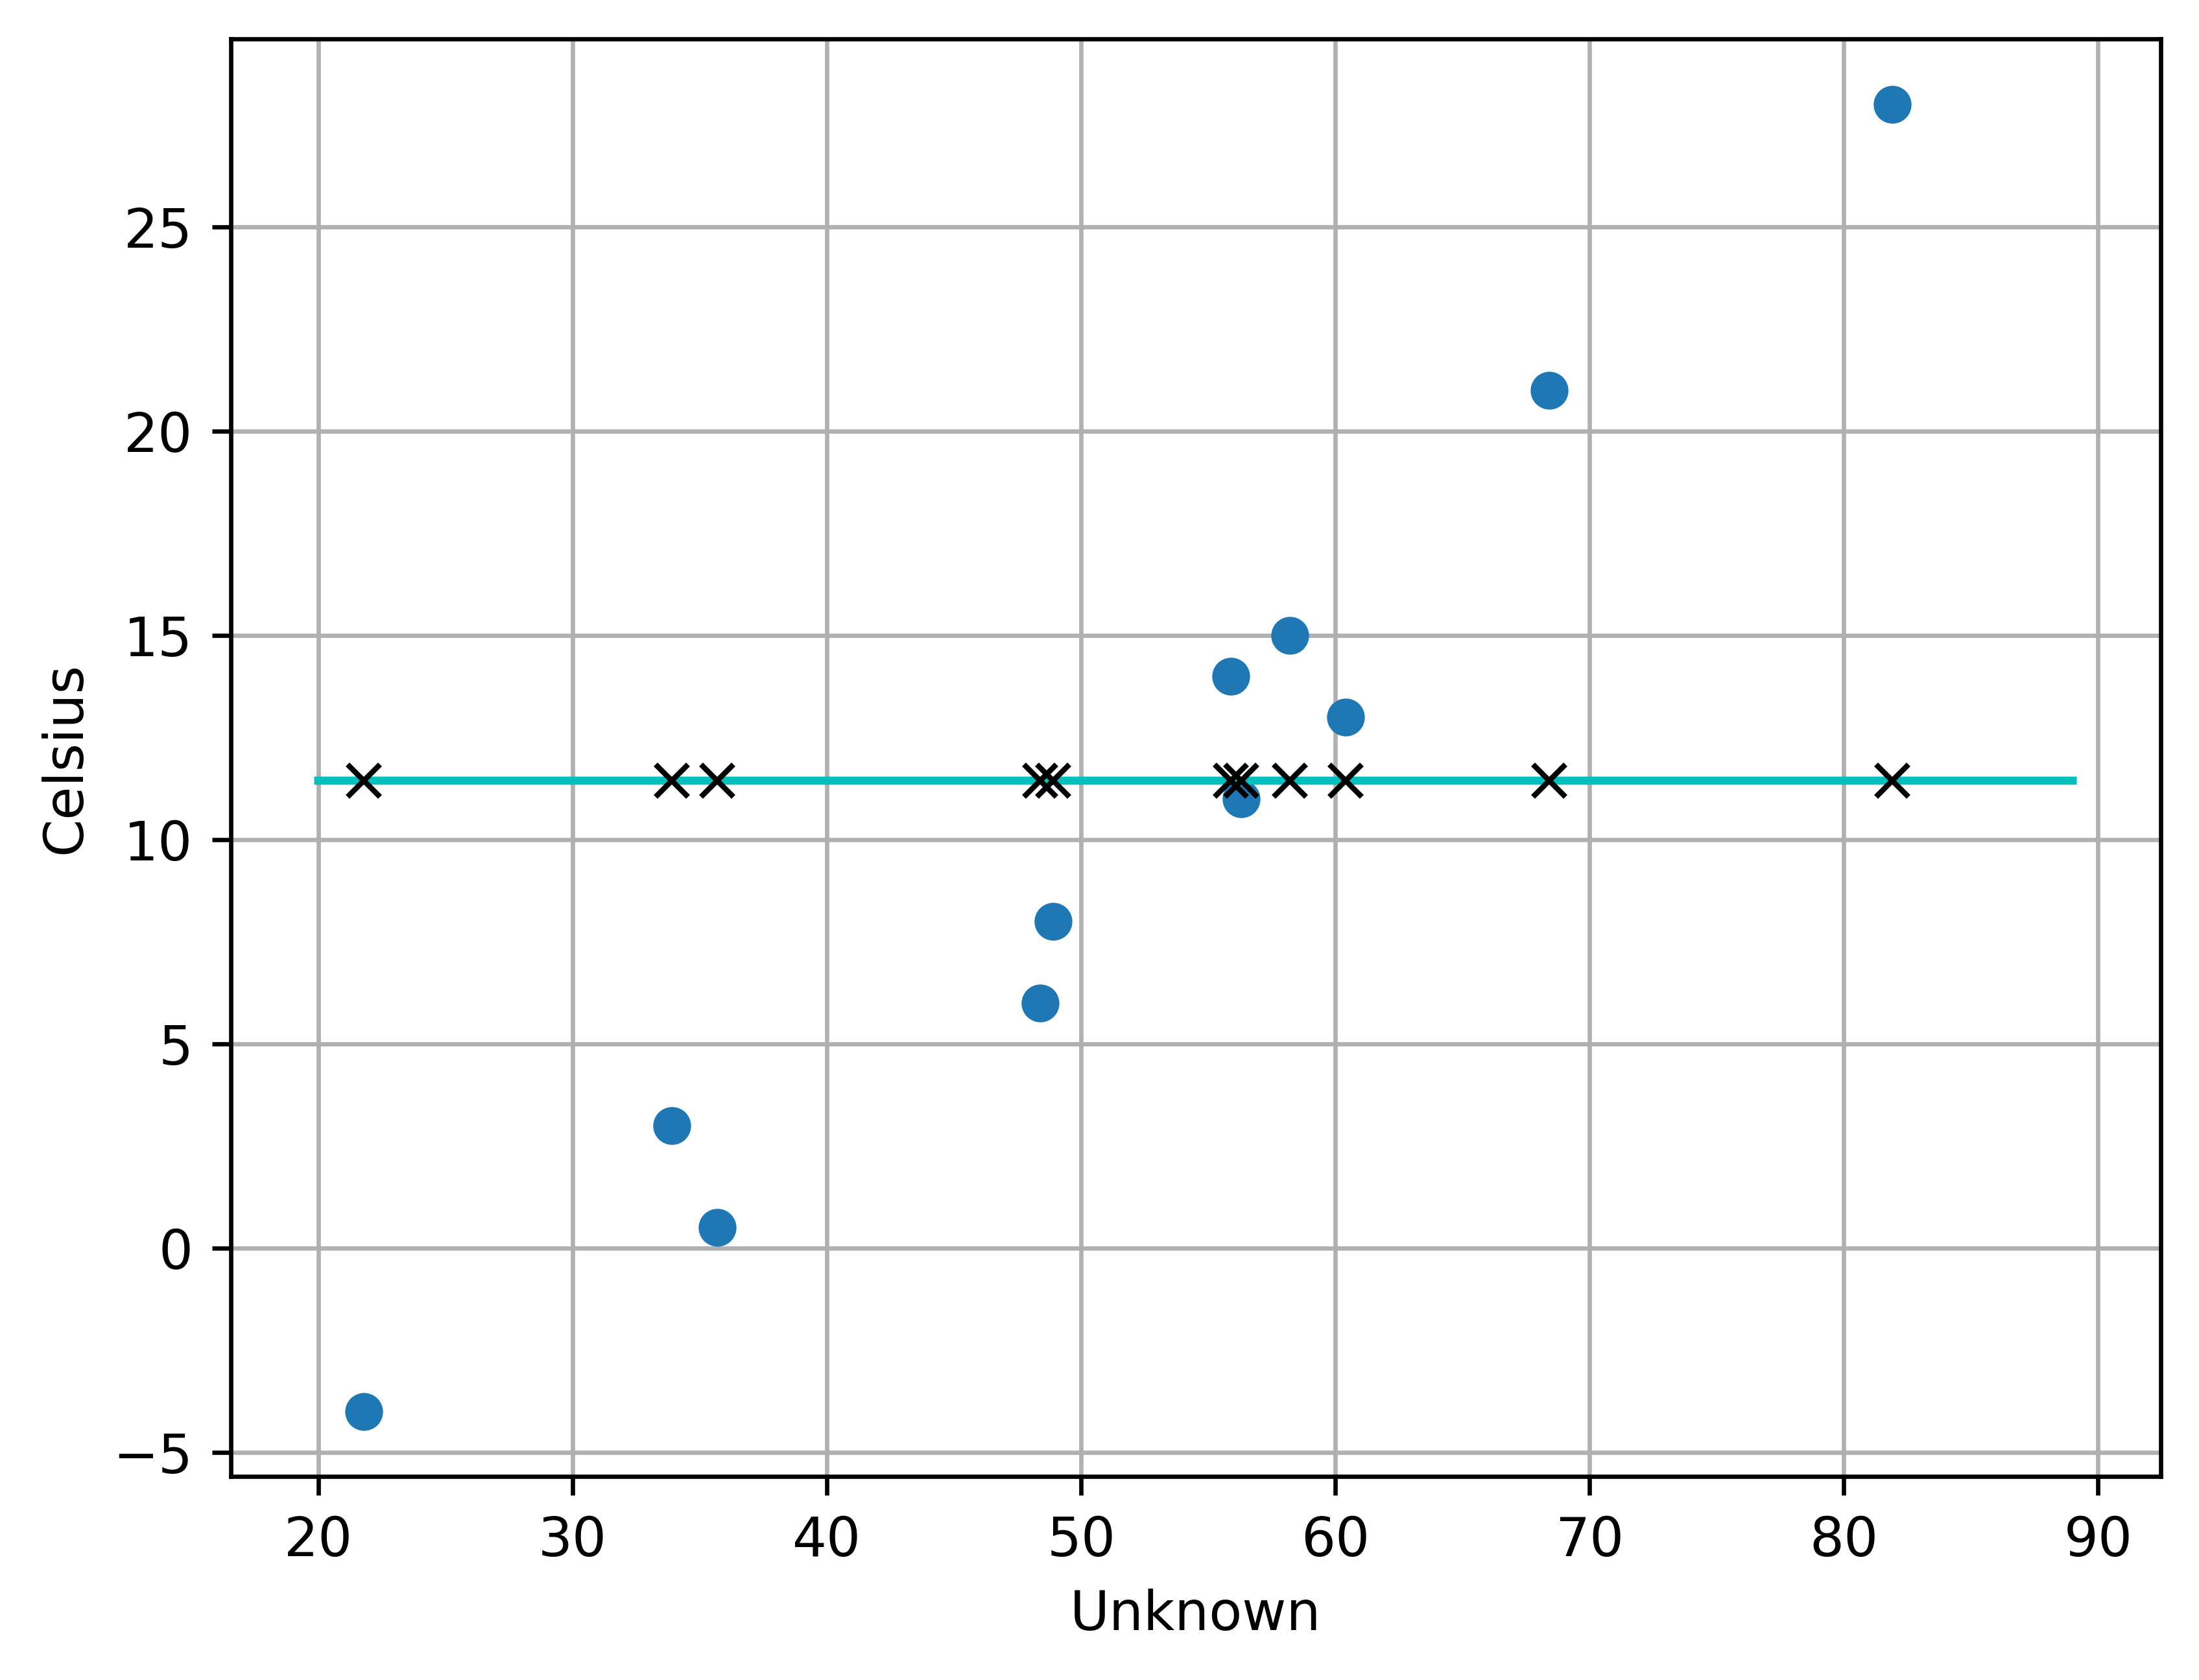

In [8]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model(t_range).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model(t_u).detach().numpy(), 'kx')

__WOAH__. The model did a awful job. Why is that?

Because we did not normalize the data range. The activation function `tanh` is saturated well above 10.

Let's normalize our unknown temperature measurements to a magnitude that is similar to $O(1)$

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=10, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=10, out_features=1, bias=True)
) torch.Size([8, 1]) torch.Size([3, 1])
Epoch 1, Training loss 245.7254, Validation loss 94.2234
Epoch 2, Training loss 238.3811, Validation loss 89.4137
Epoch 3, Training loss 230.9561, Validation loss 84.6752
Epoch 4, Training loss 223.5822, Validation loss 80.0289
Epoch 1000, Training loss 2.8282, Validation loss 6.4980
Epoch 2000, Training loss 2.5457, Validation loss 9.4630
Epoch 3000, Training loss 1.4386, Validation loss 7.9952
Epoch 4000, Training loss 1.2114, Validation loss 7.6704
Epoch 5000, Training loss 1.0192, Validation loss 7.3749
output tensor([[-0.5059],
        [15.4675],
        [ 6.8649]], grad_fn=<AddmmBackward0>)
answer tensor([[ 3.],
        [13.],
        [ 8.]])
hidden tensor([[ 5.8350e-03],
        [-8.5565e+00],
        [ 8.5073e+00],
        [-1.4134e-02],
        [-5.3423e-02],
 

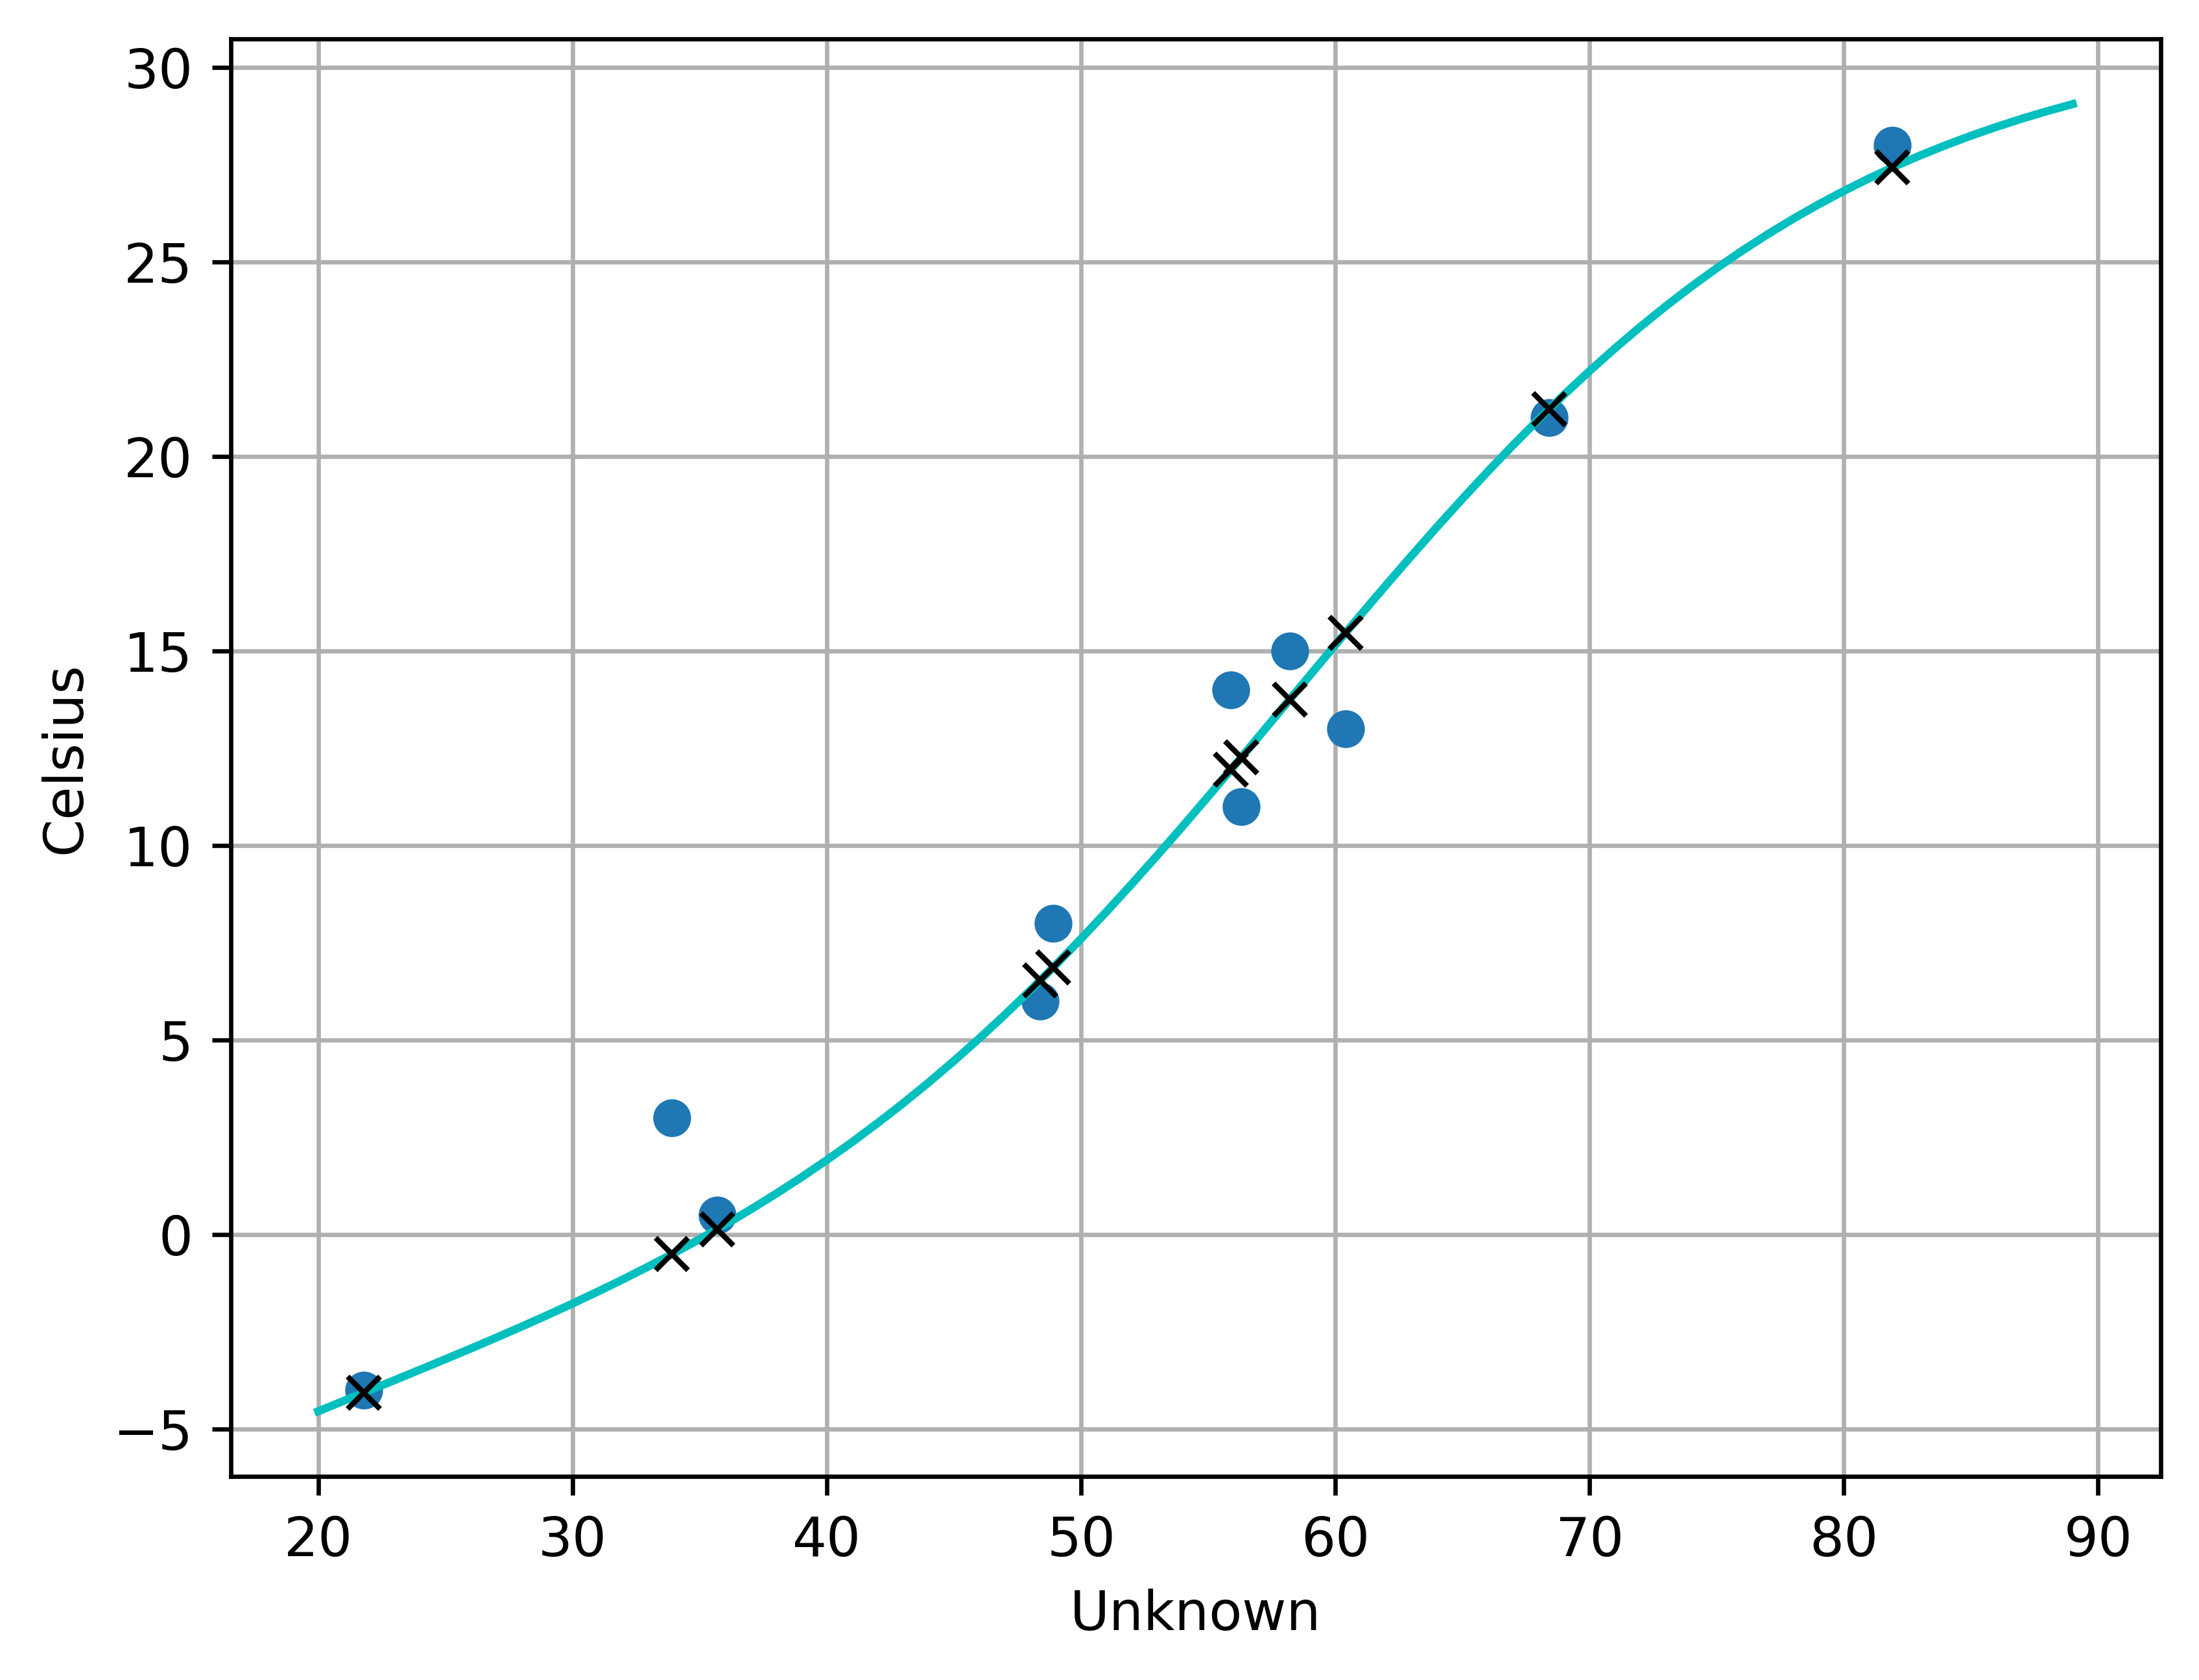

In [9]:
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
print(seq_model, t_un_train.shape, t_un_val.shape)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Much better! The crude "normalization" above rescales the range of the input. However, we observe overfitting at the extremum points.

A better approach is to set the population with mean zero and standard deviation of 1.

In [10]:
t_u_mean, t_u_std = torch.mean(t_u.squeeze()), torch.mean(t_u.squeeze())
t_un_train = (t_u_train - t_u_mean) / t_u_std
t_un_val = (t_u_val - t_u_mean) / t_u_std

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=10, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=10, out_features=1, bias=True)
) torch.Size([8, 1]) torch.Size([3, 1])
Epoch 1, Training loss 231.0585, Validation loss 81.2954
Epoch 2, Training loss 229.1573, Validation loss 80.0731
Epoch 3, Training loss 227.2880, Validation loss 78.8743
Epoch 4, Training loss 225.4489, Validation loss 77.6977
Epoch 1000, Training loss 2.1754, Validation loss 7.3679
Epoch 2000, Training loss 1.0032, Validation loss 7.0479
Epoch 3000, Training loss 0.9553, Validation loss 6.9970
Epoch 4000, Training loss 0.9505, Validation loss 7.0260
Epoch 5000, Training loss 0.9475, Validation loss 7.0641
output tensor([[-0.4991],
        [15.8628],
        [ 7.1320]], grad_fn=<AddmmBackward0>)
answer tensor([[ 3.],
        [13.],
        [ 8.]])
hidden tensor([[-0.0002],
        [-0.0024],
        [ 0.0043],
        [ 0.0059],
        [ 0.0042],
        [ 0.0101],
  

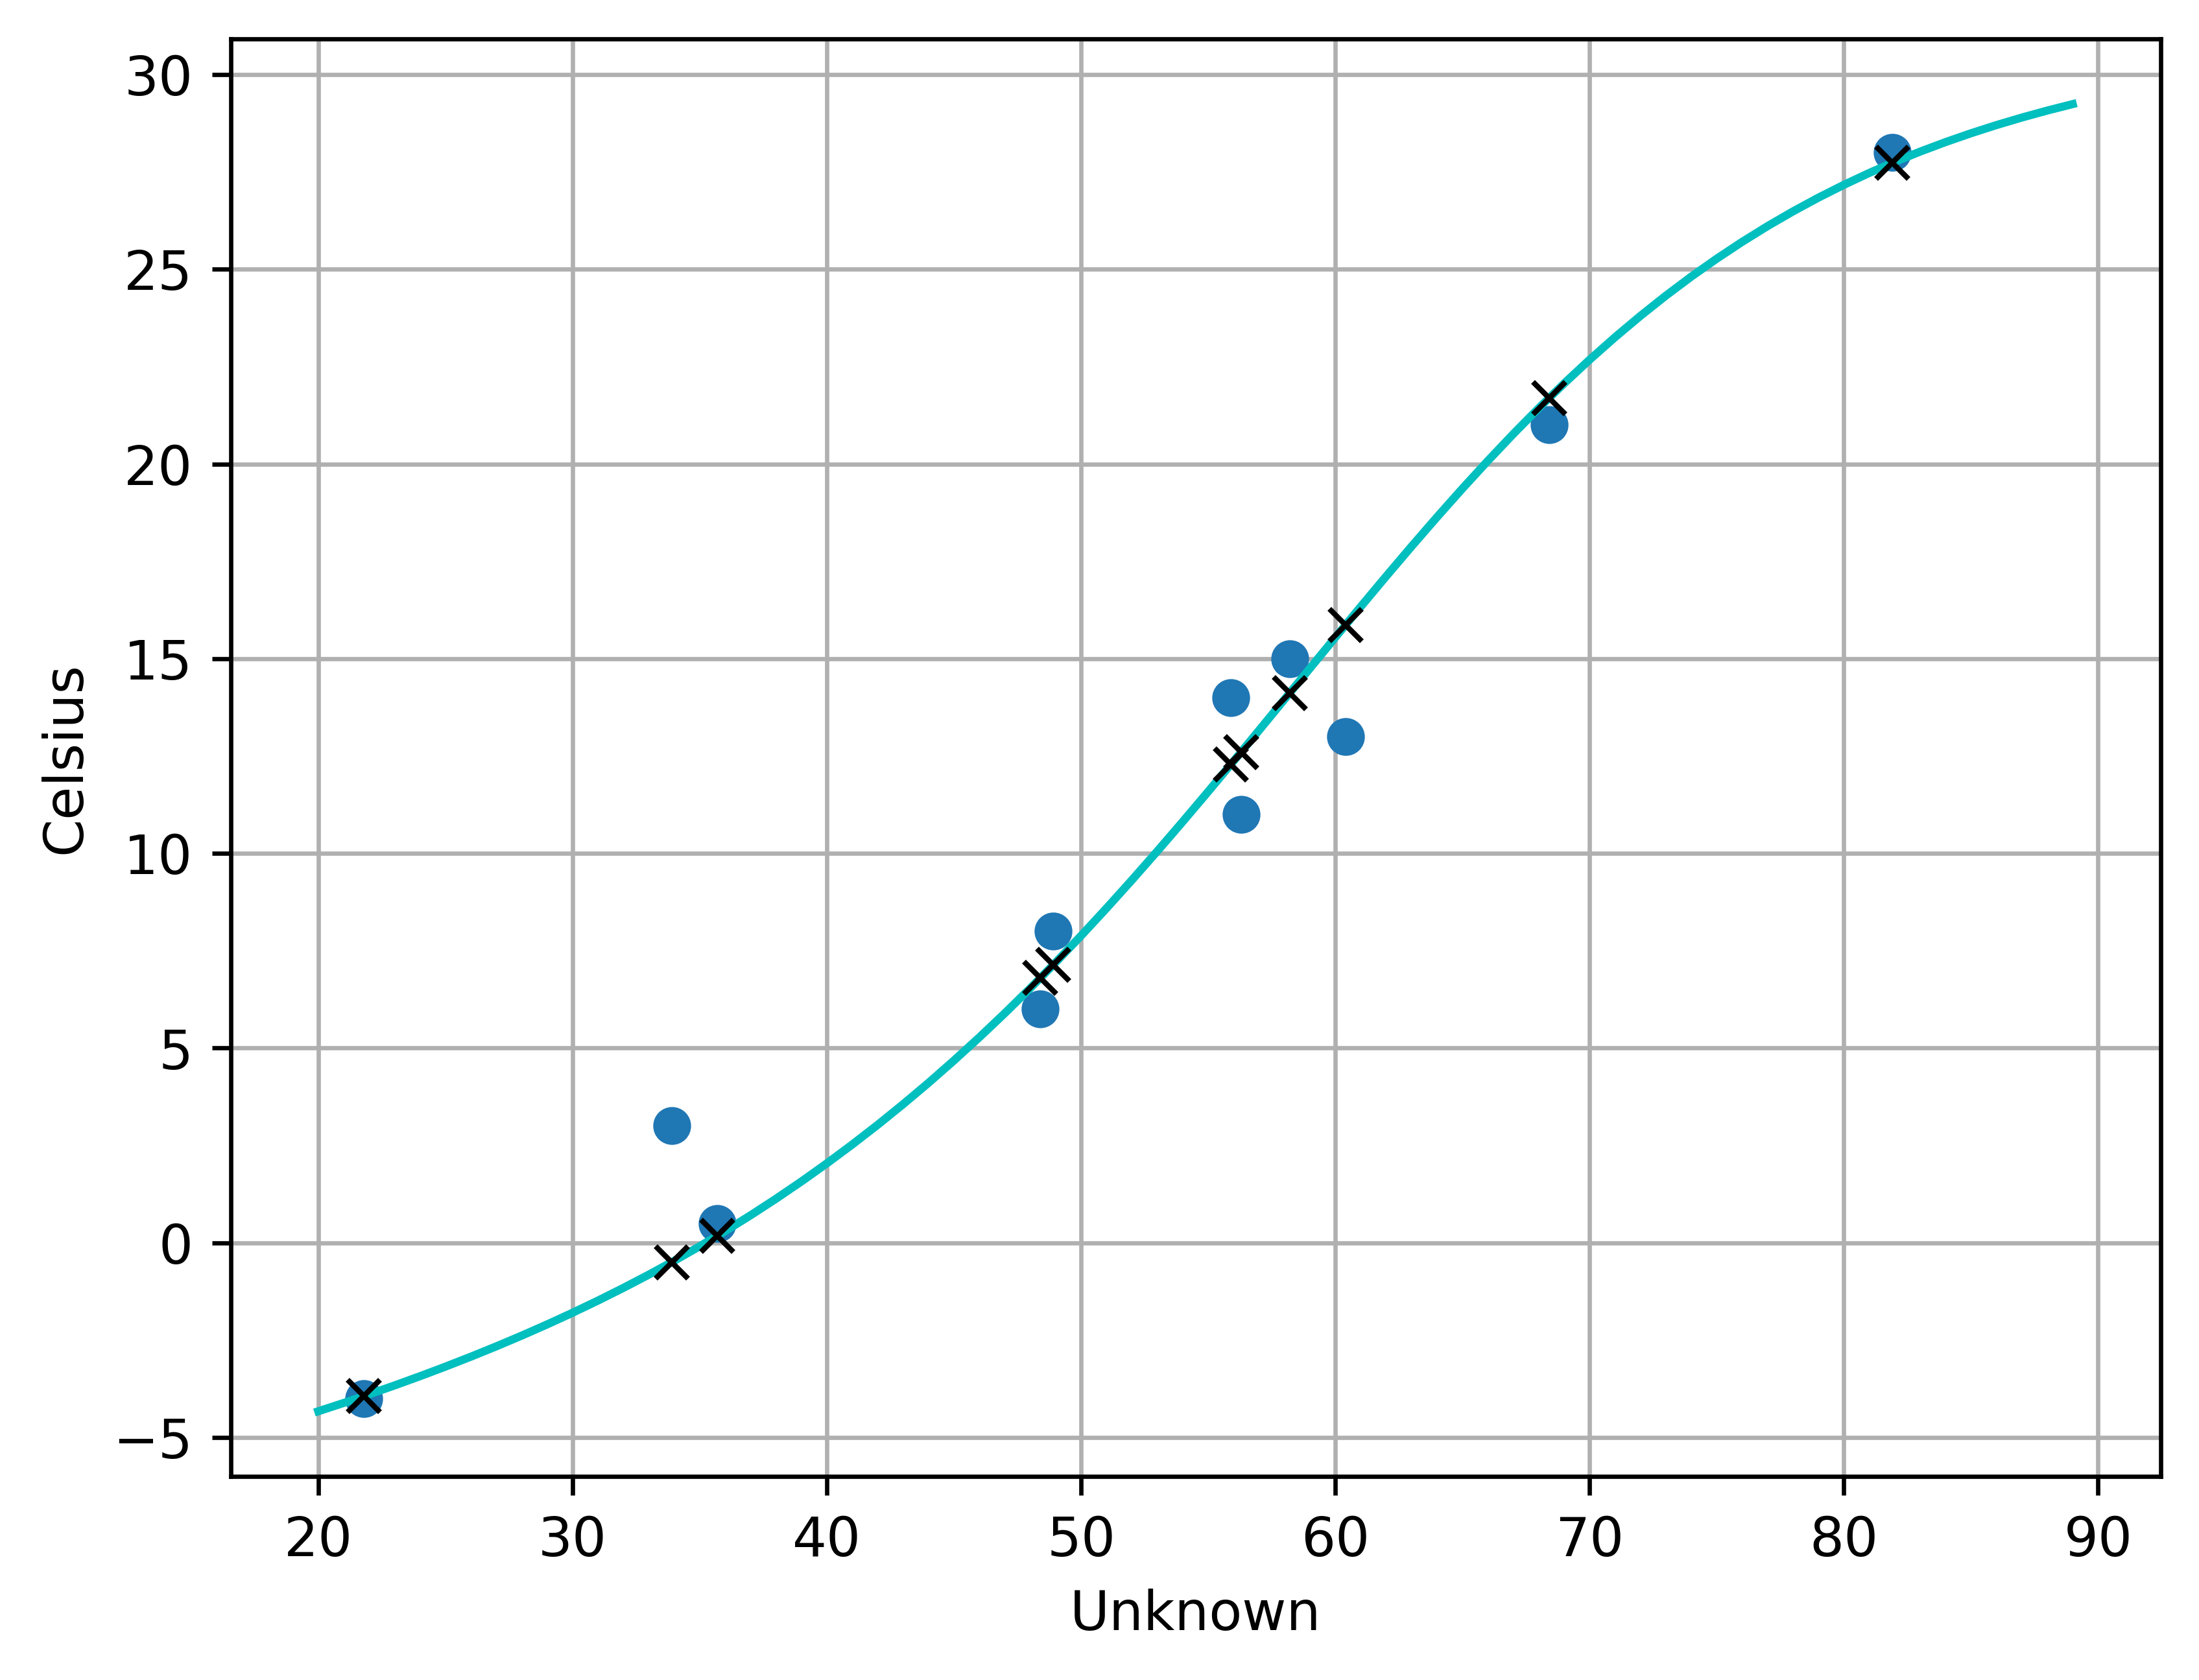

In [11]:

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
print(seq_model, t_un_train.shape, t_un_val.shape)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model((t_range - t_u_mean) / t_u_std).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model((t_u - t_u_mean) / t_u_std).detach().numpy(), 'kx')

Intuitively, we should feel that using a linear model is better here than using a NN. Simply put, we are overfitting using such a function. We could play with different activation functions, but that still is not useful.

We can see that the advantage and flexibility of NNs: model _almost_ any complicated function.